Summary Statistics for Filtered Data:
        total_day_minutes  total_day_calls  total_day_charge  total_eve_calls  \
count           5000.000         5000.000          5000.000         5000.000   
mean             180.289          100.029            30.650          100.191   
min                0.000            0.000             0.000            0.000   
max              351.500          165.000            59.760          170.000   
std               53.895           19.831             9.162           19.826   
var             2904.639          393.276            83.944          393.090   

       number_vmail_messages  total_eve_minutes  total_eve_charge  \
count               5000.000           5000.000          5000.000   
mean                   7.755            200.637            17.054   
min                    0.000              0.000             0.000   
max                   52.000            363.700            30.910   
std                   13.546             50.551        

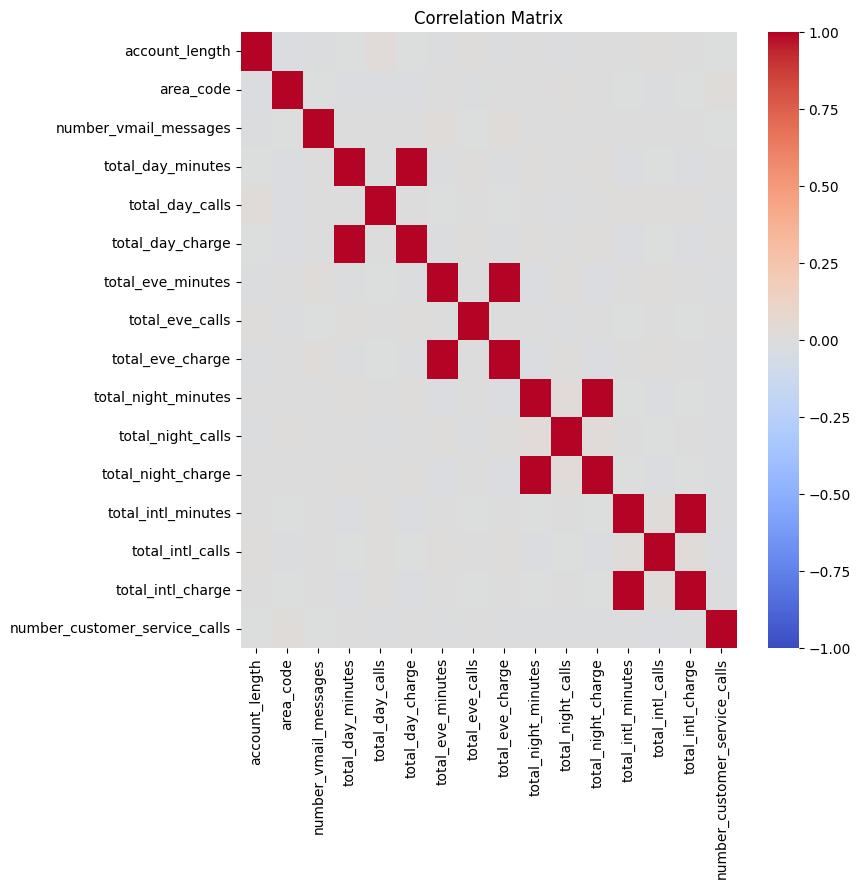


Grouped by churned:
    churned  total_day_charge  total_eve_charge  total_night_charge  \
0   False.         128264.08          72545.92            38532.22   
1    True.          24984.26          12725.69             6556.44   

   total_intl_charge  
0           11814.57  
1            2041.41  


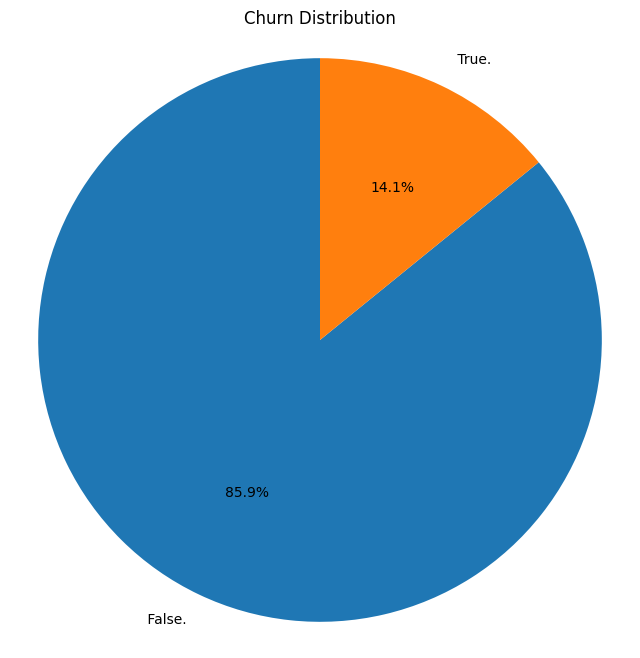

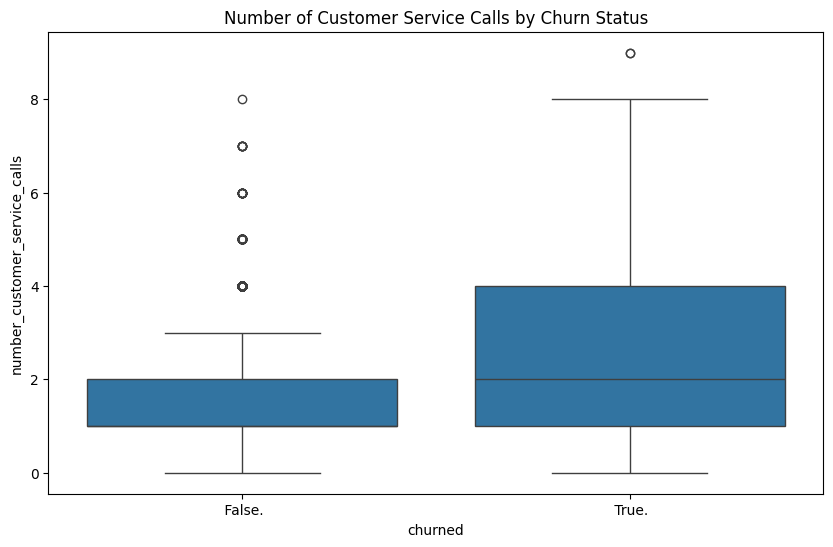

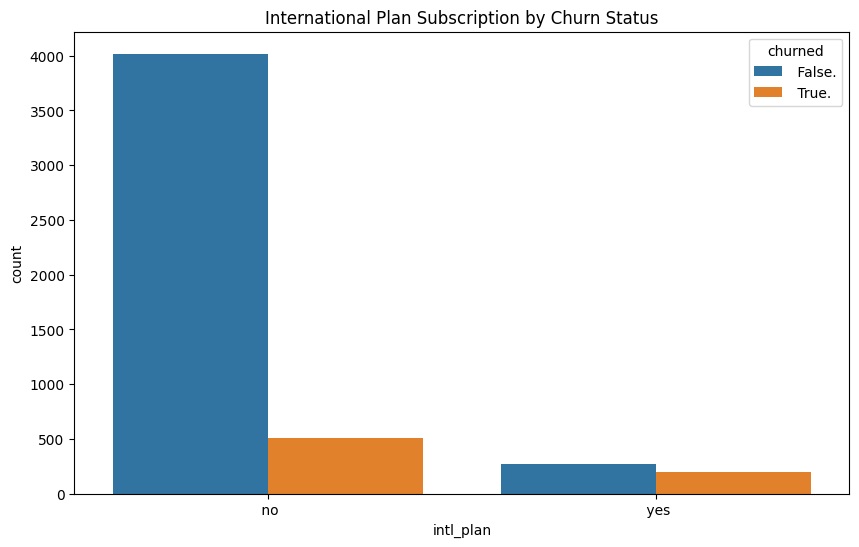

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from fire_notebook.output.workflowcontext import RestWorkflowContext

parameters_list = sys.argv
#print(parameters_list, "parameters_list")

if len(sys.argv) > 1:
    restworkflowcontext = RestWorkflowContext(parameters=parameters_list)
else:
    restworkflowcontext = RestWorkflowContext(debug=False)

message="20"
restworkflowcontext.outputProgress(9, title="Progress", progress=message)

# Set the path to the CSV file containing the dataset
#FILE_PATH = "/content/drive/MyDrive/data/churn.all" #google coollab
FILE_PATH = "churn.all"

# Read the CSV file, treating empty strings as NaN and forcing 'churned' to be read as a string
df = pd.read_csv(FILE_PATH, na_values=[''], keep_default_na=False, dtype={'churned': str})

# Define a function to filter the DataFrame based on user-specified criteria
def filter_dataframe(df, state_filter, intl_plan_filter, voice_mail_filter):
    # Create a copy of the DataFrame to avoid modifying the original
    filtered_df = df.copy()

    # Filter by state if a specific state is provided
    if state_filter != '%':
        filtered_df = filtered_df[filtered_df['state'] == state_filter]

    # Filter by international plan if a specific plan is provided
    if intl_plan_filter != '%':
        filtered_df = filtered_df[filtered_df['intl_plan'] == intl_plan_filter]

    # Filter by voice mail plan if a specific plan is provided
    if voice_mail_filter != '%':
        filtered_df = filtered_df[filtered_df['voice_mail_plan'] == voice_mail_filter]

    # Return the filtered DataFrame
    return filtered_df

# Define the filter criteria (these would typically come from user input in a web application)
state_filter = restworkflowcontext.getParmeters(parameter_name="arg_state", default='%')
intl_plan_filter = restworkflowcontext.getParmeters(parameter_name="arg_intl_plan", default='%')
voice_mail_filter = restworkflowcontext.getParmeters(parameter_name="arg_voice_mail_plan", default='%')
#churned_filter = restworkflowcontext.getParmeters(parameter_name="arg_churned", default='%')

'''
state_filter = "%"  # Select all states
intl_plan_filter = "%"  # Select all international plans
voice_mail_filter = "%"  # Select all voicemail plans
'''

# Call the filter function with the specified criteria
filtered_df = filter_dataframe(df, state_filter, intl_plan_filter, voice_mail_filter)

# Define a list of columns for which summary statistics will be computed
summary_cols = [
    # List of columns to include in the summary statistics
    "total_day_minutes", "total_day_calls", "total_day_charge", "total_eve_calls",
    "number_vmail_messages", "total_eve_minutes", "total_eve_charge",
    "total_night_minutes", "total_night_calls", "total_night_charge",
    "total_intl_minutes", "total_intl_calls", "total_intl_charge",
    "number_customer_service_calls"
]

# Compute summary statistics for the filtered DataFrame
summary_df = filtered_df[summary_cols].agg(['count', 'mean', 'min', 'max', 'std', 'var']).round(3)

# Print the summary statistics
print("Summary Statistics for Filtered Data:\n", summary_df)

restworkflowcontext.outPandasDataframe(9, "Summary Statistics for Filtered Data", summary_df)

# Drop rows with null values from the filtered DataFrame
df_drop_null = filtered_df.dropna()

# Select numeric and boolean columns for the correlation matrix calculation
numeric_bool_cols = df_drop_null.select_dtypes(include=['number', 'bool']).columns

# Calculate the correlation matrix for the numeric and boolean columns
corr_matrix = df_drop_null[numeric_bool_cols].corr()

# Print the correlation matrix
print("\nCorrelation Matrix:\n", corr_matrix)
restworkflowcontext.outPandasDataframe(9, "Correlation Matrix Table", corr_matrix)


# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.show()

# Group the filtered DataFrame by 'churned' and compute aggregated statistics
groupby_df = filtered_df.groupby('churned').agg({
    'total_day_charge': 'sum',
    'total_eve_charge': 'sum',
    'total_night_charge': 'sum',
    'total_intl_charge': 'sum'
}).reset_index()

# Print the grouped data
print("\nGrouped by churned:\n", groupby_df.head())
restworkflowcontext.outPandasDataframe(9, "Churned Statistics", groupby_df.head())


# Create a pie chart to visualize the distribution of churned and non-churned customers
churn_counts = filtered_df['churned'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Churn Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

# Create a box plot to visualize the distribution of customer service calls by churn status
plt.figure(figsize=(10, 6))
sns.boxplot(x='churned', y='number_customer_service_calls', data=filtered_df)
plt.title('Number of Customer Service Calls by Churn Status')
plt.show()

# Create a count plot to visualize the distribution of international plan subscriptions by churn status
plt.figure(figsize=(10, 6))
sns.countplot(x='intl_plan', hue='churned', data=filtered_df)
plt.title('International Plan Subscription by Churn Status')
plt.show()

progress_percentage = "100"
restworkflowcontext.outputProgress(id=9, title="Progress", progress=progress_percentage)

message = "Success."
restworkflowcontext.outSuccess(9, title="Success", text=message)

# New Section